Experimental code for metrics with a binary response.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from pedeval.experiment_design import QualifiedOnlyBRRED
import scipy

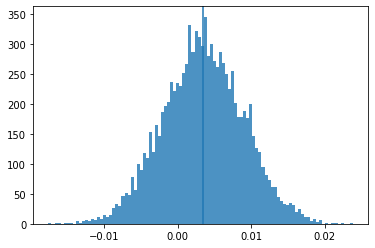

In [2]:
design3 = (
    QualifiedOnlyBRRED(p_C0=0.15, p_C1=0.16, p_I1=0.17, p_C2=0.14, p_I2=0.155, 
                       p_C3=0.2, p_Iphi=0.215, p_Ipsi=0.225,
                       n_0=10001, n_1=8201, n_2=7301, n_3=4001, alpha=0.05, pi_min=0.8)
)

samples = []
for i in range(0, 10000):
    samples.append(design3.get_actual_effect_sample())
    
plt.hist(samples, bins=100, alpha=0.8)
plt.axvline(design3.theoretical_actual_effect())
plt.show()


In [58]:
percentiles = []
N_RUNS = 500

for run in range(0, N_RUNS):
    print(f"Run: {run}/{N_RUNS}", end="\r")
    
    # initial samples
    samples = []
    for i in range(0, 1000):
        samples.append(design3.get_actual_effect_sample())
    
    # bootstrap means
    bootstrap_means = []
    for j in range(0, 200):
        bootstrap_means.append(np.mean(np.random.choice(samples, size=len(samples), replace=True)))
        
    # ranks
    percentiles.append(scipy.stats.percentileofscore(bootstrap_means, design3.theoretical_actual_effect()))
    

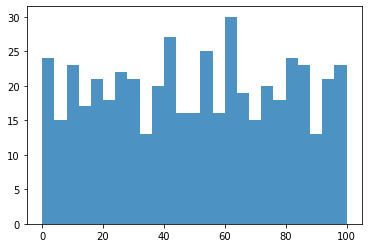

In [61]:
plt.hist(percentiles, bins=25, alpha=0.8)
plt.show()

In [3]:
percentiles = []
N_RUNS = 10
N_MDE_SIZE_SAMPLES = 100

for run in range(0, N_RUNS):
    print(f"Run: {run+1}/{N_RUNS}...", end="\r")
    
    # initial samples
    samples = []
    for mde_sample in range(0, N_MDE_SIZE_SAMPLES):
        print(f"Run: {run+1}/{N_RUNS}... MDE Size sample: {mde_sample+1}/{N_MDE_SIZE_SAMPLES}", 
              end="\r")
        samples.append(design3.get_mde_size_sample())
    
    # bootstrap means
    bootstrap_means = []
    for j in range(0, 1000):
        bootstrap_means.append(np.mean(np.random.choice(samples, size=len(samples), replace=True)))
        
    # ranks
    percentiles.append(scipy.stats.percentileofscore(bootstrap_means, design3.theoretical_mde_size()))
    

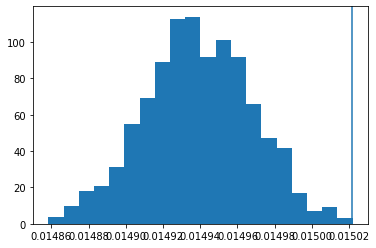

In [9]:
plt.hist(bootstrap_means, bins=20)
plt.axvline(design3.theoretical_mde_size())

(array([9., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([ 0.  ,  6.56, 13.12, 19.68, 26.24, 32.8 , 39.36, 45.92, 52.48,
        59.04, 65.6 ]),
 <a list of 10 Patch objects>)

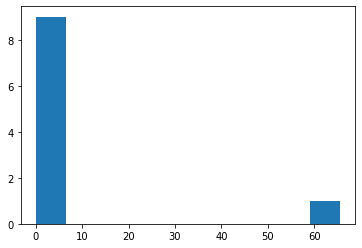

In [4]:
plt.hist(percentiles)

In [101]:
from pedeval.sampler import BinarySampler
import numpy as np
from scipy.stats import percentileofscore, norm
import noisyopt

n_null_metric_samples = 2000
n_alt_metric_samples = 500

null_metric_samples = []
alt_metric_samples = []

# For binary response, it is equivalent to either:
# 1. Sample three groups with sizes n_1, n_2, n_3 and prob p_1, p_2, p_3, or
# 2. Sample one group with size (n_1 + n_2 + n_3) and prob
#    (n_1p_1 + n_2p_2 + n_3p_3) / (n_1 + n_2 + n_3)

group_A_n = int(design3.n_1 / 2) + int(design3.n_2 / 2) + int(design3.n_3 / 2)
group_A_p = (
    (design3.n_1 * design3.p_I1 + design3.n_2 * design3.p_C2 + 
     design3.n_3 * design3.p_Iphi) /
    (design3.n_1 + design3.n_2 + design3.n_3)   
)

for sample in range(0, n_null_metric_samples):
    group_A_responses = BinarySampler(n=group_A_n, p=group_A_p).get_samples()
    group_B_responses_null = BinarySampler(n=group_A_n, p=group_A_p).get_samples()
    
    null_metric_samples.append(np.mean(group_B_responses_null) - np.mean(group_A_responses))

null_critical_value = np.percentile(null_metric_samples, (1 - design3.alpha / 2) * 100)

null_critical_value



0.011079487179487183

In [135]:
simulated_power_BRR(0.0155, group_A_n, group_A_p, null_critical_value, n_alt_metric_samples)

0.0155 0.822


0.822

In [138]:
def simulated_power(effect: float, group_A_n: int, group_A_p: int,
                    null_critical_value: float,
                    n_alt_metric_samples: int, **kwargs):
    
    alt_metric_samples = []
    
    for sample in range(0, n_alt_metric_samples):
        group_A_responses = BinarySampler(n=group_A_n, p=group_A_p).get_samples()
        group_B_responses_alt = (
            BinarySampler(n=group_A_n, p=group_A_p + effect).get_samples())
        alt_metric_samples.append(
            np.mean(group_B_responses_alt) - np.mean(group_A_responses))
        
    power = 1 - (percentileofscore(alt_metric_samples, null_critical_value) / 100)
        
    return power

In [116]:
%%time

# Speeding up the search by bounding the search space more efficiently
indicative_mde = (
    null_critical_value / norm.ppf(1-(design3.alpha/2)) *
    (norm.ppf(1-(design3.alpha/2)) - norm.ppf(1-design3.pi_min)))
search_lbound = indicative_mde * 0.8
search_ubound = indicative_mde * 1.25

# noisyopt.minimizeCompass(
#     lambda x: np.abs(simulated_power(x, group_A_n, group_A_p, 
#                                      null_critical_value, n_alt_metric_samples) -
#                      design3.pi_min),
#     x0=[indicative_mde],
#     bounds=[[search_lbound, search_ubound]],
#     deltainit=1, deltatol=0.0001,
#     funcNinit=30,
#     paired=False,
# )

CPU times: user 1.66 ms, sys: 86 µs, total: 1.75 ms
Wall time: 2.73 ms


In [139]:
%%time

noisyopt.bisect(
    noisyopt.AveragedFunction(
        lambda x: simulated_power(x, group_A_n, group_A_p, 
                                  null_critical_value, n_alt_metric_samples) -
                  design3.pi_min,
        N=20),
    search_lbound, search_ubound, 
    xtol=0.00005, errorcontrol=True, 
    testkwargs={'alpha': 0.005, 'eps': 0.0005, 'maxN': 640},
    outside='extrapolate', ascending=True, disp=True)

bisect bounds 0.012669672606706657 0.01583709075838332
bisect bounds 0.014253381682544988 0.01583709075838332
bisect bounds 0.015045236220464154 0.01583709075838332
bisect bounds 0.015441163489423737 0.01583709075838332
bisect bounds 0.015441163489423737 0.01563912712390353
bisect bounds 0.015441163489423737 0.015540145306663634
bisect bounds 0.015490654398043684 0.015540145306663634
bisect final value 0.015580174718047417
CPU times: user 35.3 s, sys: 509 ms, total: 35.9 s
Wall time: 42.3 s


0.015580174718047417